# DQN algrorithm with BigDL

In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

init_engine()

In [2]:
def get_pred(array, agent):
    prediction = agent.model.predict(sc.parallelize(array).zip(sc.parallelize([0])).map(
            lambda x: Sample.from_ndarray(x[0], x[1])))
    
    return prediction.take(1)[0]

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.99, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.errors = 0

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, self.action_size))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = get_pred(state, self)
        return np.argmax(act_values)  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        #local_batch.extend(minibatch)
        t = 0
        data_batch = []
        target_batch = []
        for state, action, reward, next_state, done in minibatch:
            t+=1
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.forward(next_state)))
            target_f = self.model.forward(state[0])
            target_f[action] = target
            data_batch.append(state[0])
            target_batch.append(target_f)
            if t == 4:
                batch_rdd = sc.parallelize(data_batch).zip(sc.parallelize(target_batch)).map(
                lambda x: Sample.from_ndarray(x[0], x[1]))
                optimizer = Optimizer(model=self.model,
                                      training_rdd=batch_rdd,
                                      criterion=MSECriterion(),
                                      optim_method=Adam(learningrate=self.learning_rate),
                                      end_trigger=MaxIteration(1),
                                      batch_size=4)
                trained_model=optimizer.optimize()
                self.model = trained_model
                self.model.evaluate()
                data_batch = []
                target_batch = []
                t=0
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [4]:
%%time
EPISODES=1000
conf = create_spark_conf()
sc = SparkContext.getOrCreate(conf)

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
done = False
batch_size = 128
results=[]

[2017-11-17 17:49:10,581] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
CPU times: user 56 ms, sys: 16 ms, total: 72 ms
Wall time: 231 ms


In [ ]:
%%time
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done or time == 498:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            results.append(time)
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

episode: 0/1000, score: 9, e: 1.0
episode: 1/1000, score: 17, e: 1.0
episode: 2/1000, score: 15, e: 1.0
episode: 3/1000, score: 19, e: 1.0
episode: 4/1000, score: 8, e: 1.0
episode: 5/1000, score: 34, e: 1.0
episode: 6/1000, score: 11, e: 1.0
episode: 7/1000, score: 19, e: 1.0
creating: createMSECriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxIteration
creating: cre

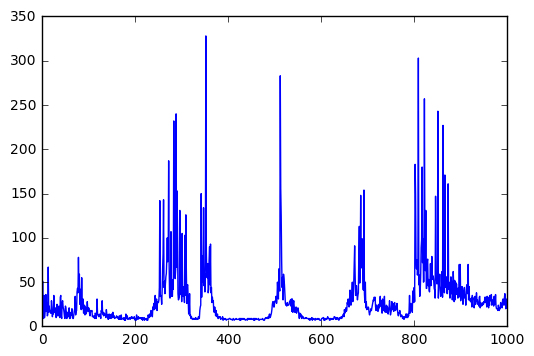

In [42]:
plt.plot(results)
plt.show()

In [43]:
state = env.reset()
done = False
while not done:
    values = agent.model.forward(state)
    print(values)
    state,_, done, _ = env.step(np.argmax(values))

[-17.24607277 -21.1901474 ]
[-17.87919998 -19.4160881 ]
[-19.91220093 -19.55477524]
[-18.08315468 -19.516716  ]
[-20.15510941 -19.74132729]
[-18.40693665 -19.66389465]
[-20.5290432 -20.0087204]
[-18.87137604 -19.85971069]
[-21.04179001 -20.3631382 ]
[-19.54504013 -20.22374725]
[-21.7044239  -20.81280708]
[-20.41685295 -20.70513153]
[-22.50749207 -21.35488892]
[-21.361763   -21.30507278]
[-19.58008766 -22.13147163]
[-22.30064774 -21.91049767]
[-20.71067429 -22.52524757]
[-23.36501884 -22.6016655 ]
[-22.13895226 -23.08479309]
[-24.53191376 -23.36840248]
[-23.65239334 -23.77303314]
[-25.85651016 -24.24418259]
[-25.15227509 -24.60721016]
[-23.81100273 -25.68788147]
[-26.60913467 -25.47492981]
[-25.87864304 -26.49193192]
[-28.23522377 -26.4844265 ]


In [29]:
state=env.reset()
get_pred([state], agent)[0]

0.23965843

In [21]:
get_pred(state, agent) 

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 28.0 failed 1 times, most recent failure: Lost task 2.0 in stage 28.0 (TID 33, localhost): Layer info: Sequential[cb98cfb5]{
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
  (1): Linear[e1126908](4 -> 24)
  (2): ReLU[8a516986](0.0, 0.0)
  (3): Linear[dac5abe1](24 -> 24)
  (4): ReLU[d7e0ac0b](0.0, 0.0)
  (5): Linear[d9a9ef7d](24 -> 2)
}/Linear[e1126908](4 -> 24)
java.lang.IllegalArgumentException: requirement failed: Linear: 
 The input to the layer needs to be a vector(or a mini-batch of vectors);
 please use the Reshape module to convert multi-dimensional input into vectors
 if appropriate"
    input dim 3
	at scala.Predef$.require(Predef.scala:233)
	at com.intel.analytics.bigdl.nn.Linear.updateOutput(Linear.scala:85)
	at com.intel.analytics.bigdl.nn.Linear.updateOutput(Linear.scala:45)
	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:280)
	at com.intel.analytics.bigdl.nn.Sequential.updateOutput(Sequential.scala:39)
	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:280)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:72)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:71)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:371)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:115)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:110)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1817)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)

	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:286)
	at com.intel.analytics.bigdl.nn.Sequential.updateOutput(Sequential.scala:39)
	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:280)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:72)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:71)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:371)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:115)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:110)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1817)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:748)
Caused by: Layer info: Sequential[cb98cfb5]{
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
  (1): Linear[e1126908](4 -> 24)
  (2): ReLU[8a516986](0.0, 0.0)
  (3): Linear[dac5abe1](24 -> 24)
  (4): ReLU[d7e0ac0b](0.0, 0.0)
  (5): Linear[d9a9ef7d](24 -> 2)
}/Linear[e1126908](4 -> 24)
java.lang.IllegalArgumentException: requirement failed: Linear: 
 The input to the layer needs to be a vector(or a mini-batch of vectors);
 please use the Reshape module to convert multi-dimensional input into vectors
 if appropriate"
    input dim 3
	at scala.Predef$.require(Predef.scala:233)
	at com.intel.analytics.bigdl.nn.Linear.updateOutput(Linear.scala:85)
	at com.intel.analytics.bigdl.nn.Linear.updateOutput(Linear.scala:45)
	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:280)
	at com.intel.analytics.bigdl.nn.Sequential.updateOutput(Sequential.scala:39)
	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:280)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:72)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:71)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:371)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:115)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:110)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1817)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)

	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:286)
	at com.intel.analytics.bigdl.nn.Sequential.updateOutput(Sequential.scala:39)
	at com.intel.analytics.bigdl.nn.abstractnn.AbstractModule.forward(AbstractModule.scala:280)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:72)
	at com.intel.analytics.bigdl.optim.Predictor$$anonfun$predict$1$$anonfun$apply$3.apply(Predictor.scala:71)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:371)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:115)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:110)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1817)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)
